# Climate Change Belief Analysis 2022

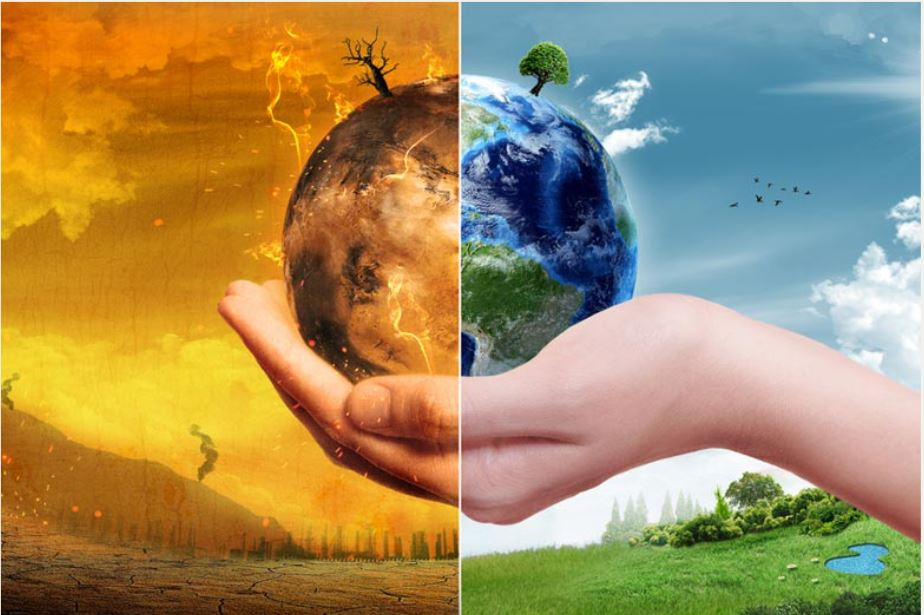

# 1.0 Introduction

# 2.0 Importing Libraries

In [1]:
import numpy as np
import pandas as pd

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

# plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
sns.set()
from collections import Counter

# 3.0 Loading Data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')

The dataframes will be copied so as to make sure the initial dataframe do not change. 

In [3]:
df_train2 = df_train.copy()
df_test2 = df_test.copy()

Let’s check the first few rows of the both datasets.

In [4]:
df_train2.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
df_test2.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# 4.0 Data Preprocessing

Initial data cleaning requirements that we can think of after looking at the top 5 records:

- The Twitter handles are not masked. We will maske them as *@user*.

- The URLs are also not masked. We will mask them as *url*.

- We also get rid of the punctuations, numbers and special characters as they add no value to the machine learning process.

- Most of the smaller words do not add much value. For example, ‘of’, ‘his’, ‘all’. These are called *stopwords*. We will remove them from our data.

- Once we have executed the above steps, we can split every Tweet into individual words. i.e tokens, which is an essential step in any NLP task.

- In the 5th tweet of the train dataset, there is a word ‘racist’. We might also have terms like racism, race, racial, racialist etc. in the rest of the data. These terms are often used in the same context. If we can reduce them to their root word, which is ‘race’, then we can reduce the total number of unique words in our data without losing a significant amount of information. This process is known as *lemmatization*.

- Converting all text to one case. Lowercase will be used here.

But first, let us start by doing the most basic data cleaning processes which include;
- Checking if there are any nulls in the datasets
- Checking if any strings in the datasets are empty

## 4.1 Checking for Null Entries

In [6]:
# Checking nulls in the train set
df_train2.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [7]:
# Checking nulls in the test set
df_test2.isnull().sum()

message    0
tweetid    0
dtype: int64

Both datasets have no *Null* values, therefore, no action needs to be taken at this stage.

## 4.2 Checking for Empty Strings

In [8]:
# checking for empty strings in the train dataframe
# start with an empty list
empty_str = [] 

# iterate over the dataframe
for i,sentiment,message,tweetid in df_train2.itertuples():  
    # only loop through string values
    if type(message)==str:            
        # check for whitespace
        if message.isspace():         
            # if true, append index numbers to empty_str list
            empty_str.append(i)     
        
print(len(empty_str), 'Empty String(s): ', empty_str)

0 Empty String(s):  []


In [9]:
# checking for empty strings in the test dataframe
# start with an empty list
empty_str = [] 

# iterate over the dataframe
for i,message,tweetid in df_test2.itertuples():  
    # only loop through string values
    if type(message)==str: 
        # check for whitespace
        if message.isspace():
            # if true, append index numbers to empty_str list
            empty_str.append(i)     
        
print(len(empty_str), 'Empty String(s): ', empty_str)

0 Empty String(s):  []


Both datasets have no empty strings, therefore, no action needs to be taken at this stage.

## 4.3 Masking User Handles

We are masking the Twitter handles with @user because;
- of privacy concerns. 
- they hardly give any information about the nature of the tweet/sentiments
- having different handle names will add to the total number of unique words in our data 

In [10]:
# masking handles names to @user on train dataset
# define the regular pattern to recognize user handles 
regex_pattern = r'\B@\w+'
# define the substitute text that will be used to replace handle name
sub_text = r'@user'
# replace user handle with substitute text
df_train2['message'] = df_train2['message'] .replace(to_replace = regex_pattern, value = sub_text, regex = True)

In [11]:
# masking handles names to @user on test dataset
# define the regular pattern to recognize user handles 
regex_pattern = r'\B@\w+'
# define the substitute text that will be used to replace handle name
sub_text = r'@user'
# replace user handle with substitute text
df_test2['message'] = df_test2['message'] .replace(to_replace = regex_pattern, value = sub_text, regex = True)

Let us check if the masking was sucessful. 

In [12]:
df_train2.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @user: Researchers say we have three years ...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @user: It's 2016, and a racist, sexist, cli...",466954


In [13]:
df_test2.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@user @user @user @user \nPutin got to you too...,476263
4,RT @user: 'Female orgasms cause global warming...,872928


We have successfully masked the user handles for both the train and test dataframes. 

## 4.4 Masking URLs

URLs will be masked for the same reasons we masked user handles

In [14]:
# masking URLs to url-web on train and test datasets
# define the regular pattern to recognize the URLs
regex_pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
# define the substitute text that will be used to replace the URLs
sub_text = r'url'

# replace URLs with substitute text on train datatset
df_train2['message'] = df_train2['message'] .replace(to_replace = regex_pattern, value = sub_text, regex = True)

# replace URLs with substitute text on test datatset
df_test2['message'] = df_test2['message'] .replace(to_replace = regex_pattern, value = sub_text, regex = True)

## 4.5 Delete Punctuations, Numbers and Special Characters

This step is necessary because punctuations, numbers and special characters don't help in differentiating different kinds of tweets. If we skip this step, there is a higher chance that we will be working with noisy and inconsistent data. We will be replacing everything except characters and hashtags with spaces.

In [15]:
# remove special characters, numbers, punctuations on train and test datasets
# define the regular pattern 
regex_pattern = r'[^a-zA-Z#]'
# define the substitute text as a whitespace
sub_text = r' '

# replace the characters on train dataframe
df_train2['message'] = df_train2['message'] .replace(to_replace = regex_pattern, value = sub_text, regex = True)

# replace the characters on test dataframe
df_test2['message'] = df_test2['message'] .replace(to_replace = regex_pattern, value = sub_text, regex = True)

## 4.6 Removing Stopwords, Converting Words to Lowercase, and Lemmatizing

Stopwords do not contribute much to the machine learning model, so it's good to remove them. A list of stopwords have been defined by the Natural Language Toolkit (nltk) library so we will start by downloading them.

Lemmatization is defined as "doing things properly using vocabulary and morphological analysis of words"<sup>1</sup>. This process returns the base form of a word, i.e, the *lemma*.
Example: Better - Good. For this step,  we will download WordNet from nltk. WordNet is a lexical database of Englishwhich helps find conceptual relationships between words.<sup>2</sup>

In [16]:
# downloading stopwrods from nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# initialize set of stopwords from English dictionary
stop_words = set(stopwords.words("english")) 
# initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

# define function to clean the tweets
def clean_tweet(text):
    # convert the text to lowercase
    text = text.lower()
    # lemmatization + tokenization process
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    # removing stopwords
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

# cleaning train dataset
df_train2['cleaned_message'] = df_train2.message.apply(lambda x: clean_tweet(x))

# cleaning test dataset
df_test2['cleaned_message'] = df_test2.message.apply(lambda x: clean_tweet(x))

Let us have a look at what the clean data looks like!

In [18]:
# checking the preprossed train dataframe 
df_train2.head()

,sentiment,message,tweetid,cleaned_message
0,1,PolySciMajor EPA chief doesn t think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...
1,1,It s not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warm
2,2,RT user Researchers say we have three years ...,698562,rt user researcher say three year act climat...
3,1,#TodayinMaker# WIRED was a pivotal year...,573736,#todayinmaker# wire wa pivotal year war...
4,1,RT user It s and a racist sexist cli...,466954,rt user racist sexist climate change...


In [19]:
# checking the preprossed test dataframe 
df_test2.head()

,message,tweetid,cleaned_message
0,Europe will now be looking to China to make su...,169760,europe look china make sure alone fight climat...
1,Combine this with the polling of staffers re c...,35326,combine poll staffer climate change woman rig...
2,The scary unimpeachable evidence that climate...,224985,scary unimpeachable evidence climate change a...
3,user user user user Putin got to you too ...,476263,user user user user putin get jill tru...
4,RT user Female orgasms cause global warming...,872928,rt user female orgasm cause global warm ...


The preprocessed dataframes look good! We will not move to Exploratory Data Analysis.

# 5.0 Exploratory Data Analysis

In this step, we will start by checking the News, Pro, Neutral and Anti messages frequency distribution in the train dataframe.  

In [20]:
# initialize news, pro, neutral and anti messages
news = df_train2[df_train2['sentiment'] == 2]['cleaned_message']
pro = df_train2[df_train2['sentiment'] == 1]['cleaned_message']
neutral =df_train2[df_train2['sentiment'] == 0]['cleaned_message']
anti = df_train2[df_train2['sentiment'] ==-1]['cleaned_message']

print('Number of news tagged sentences is:     {}'.format(len(news)))
print('Number of pro tagged sentences is:      {}'.format(len(pro)))
print('Number of neutral tagged sentences is:  {}'.format(len(neutral)))
print('Number of anti tagged sentences is:     {}'.format(len(anti)))
print('Total length of the data is:            {}'.format(df_train2.shape[0]))

Number of news tagged sentences is:     3640
Number of pro tagged sentences is:      8530
Number of neutral tagged sentences is:  2353
Number of anti tagged sentences is:     1296
Total length of the data is:            15819


Considering the size of the dataset, the count of sentenses do not seem to be equally distributed between **news, pro, neutral** and **anti**.  **Pro** has the most number of Tweets followed by **news** then **neutral** and finally **anti**.

We can now analyse the data to get further understanding of it by plotting word clouds for news, pro, netral and anti tweet messages from our train dataset and see which words occur the most.

A word cloud is a collection of words depicted in different sizes. The bigger and bolder the word appears, the more often it's mentioned within a dataset. We will used the WordCloud library for this scenario. 

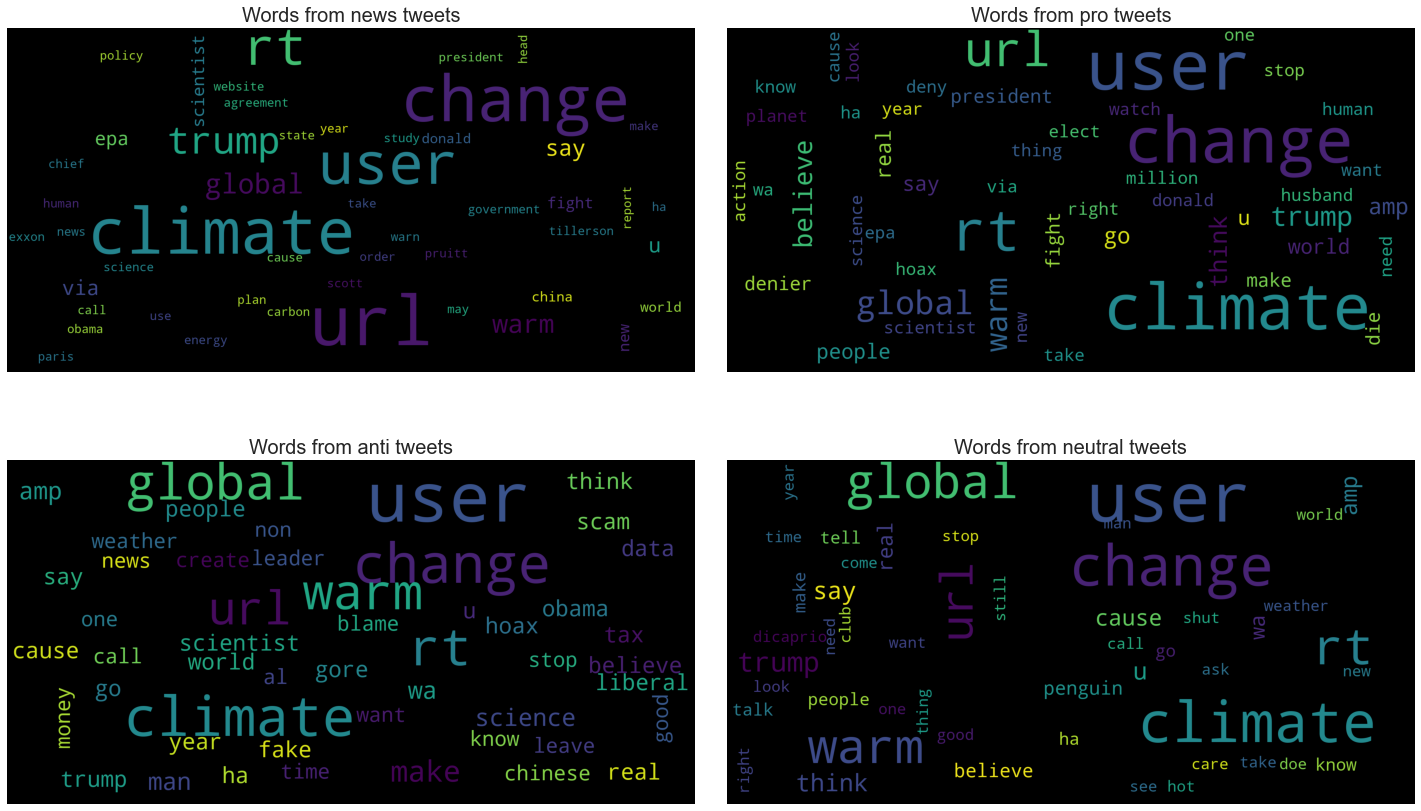

In [21]:
news = [word for line in news for word in line.split()]
pro = [word for line in pro for word in line.split()]
neutral = [word for line in neutral for word in line.split()]
anti= [word for line in anti for word in line.split()]

news = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(news))

pro = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(pro))



neutral = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral))


anti = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(anti))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(news)
axs[0, 0].set_title('Words from news tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(pro)
axs[0, 1].set_title('Words from pro tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)


# axs[1, 0].tight_layout(pad = 1)
axs[1, 0].imshow(anti)
axs[1, 0].set_title('Words from anti tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(neutral)
axs[1, 1].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 1].axis('off')

# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')

Let us now graphically show the frequency of the first 25 words on the train dataset.

In [ ]:
print(anti)

# 6.0 Modeling

# 7.0 Conclusion

# 8.0 Appendix

1. Stemming and lemmatization - Stanford NLP Group: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
2. Source code for nltk.corpus.reader.wordnet: https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html